In [1]:
import pandas as pd
import numpy as np
import rdkit.Chem as Chem
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
js = pd.read_csv('janssen_primary_sulfonamides_md.csv')
rx = pd.read_csv('reaxys_primary_sulfonamides_md.csv')
lit = pd.read_csv('literature_primary_sulfonamides_md.csv')
sel = pd.read_csv('scope_smiles.csv')

In [3]:
len(js)

971

In [4]:
len(rx)

3547

In [5]:
js['type'] = 'Janssen'
rx['type'] = 'Reaxys'
lit['type'] = 'Literature'

In [6]:
# merge dfs, keeping all literature compounds labeled as literature, most janssen compounds labeled as janssen, and the rest labeled as reaxys
df = pd.concat([lit, js, rx]).drop_duplicates('inchi').dropna(axis=1).reset_index(drop=True)

# Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler
from scipy.linalg import qr

In [8]:
# Remove non-numerical descriptors

df_object = df.select_dtypes(include='object').columns
info = df[df_object]
df = df.select_dtypes(exclude='object')

In [9]:
# scale df
scaler = StandardScaler().fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)

In [10]:
# drop linearly dependent columns

tol = 1e-8
q, r, p = qr(df, pivoting=True)
rank = sum(np.abs(np.diag(r)) > tol)
col_ind_to_keep = p[:rank]
col_ind_to_drop = p[rank:]
lin_dep = df[df.columns[col_ind_to_drop]].columns
df = df[df.columns[col_ind_to_keep]]

In [11]:
# drop highly correlated columns 

df_corr = df.corr().abs()
upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(to_drop, axis=1)

/var/folders/_7/9sd8g_d51p323k3f1njm9pnc0000gn/T/ipykernel_5416/1502587614.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))


# Dimensionality reduction

In [12]:
from sklearn.decomposition import PCA
from umap import UMAP

In [13]:
dfs={}
dfs['all'] = df

# 2D PC
dfs['pc2'] = pd.DataFrame(PCA(n_components=2, random_state=0).fit_transform(df),
                      index=df.index,
                      columns=['PC1', 'PC2'])

# 2D UMAP
nneigh = np.int(np.sqrt(df.shape[1]))
dfs['umap2'] = pd.DataFrame(UMAP(n_components=2,
                             n_neighbors=nneigh, random_state=0).fit_transform(df),
                        index=df.index,
                        columns=['UMAP1', 'UMAP2'])

/var/folders/_7/9sd8g_d51p323k3f1njm9pnc0000gn/T/ipykernel_5416/3863446838.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nneigh = np.int(np.sqrt(df.shape[1]))
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
# merge the embeddings with info

umap_reduced = pd.merge(left=info, right=dfs['umap2'], left_index=True, right_index=True)
umap_reduced = umap_reduced.sort_values('type', key=lambda s: s.apply(['Reaxys', 'Janssen', 'Literature'].index), ignore_index=True)

pc_reduced = pd.merge(left=info, right=dfs['pc2'], left_index=True, right_index=True)
pc_reduced = pc_reduced.sort_values('type', key=lambda s: s.apply(['Reaxys', 'Janssen', 'Literature'].index), ignore_index=True)

In [21]:
pc = PCA(n_components=2, random_state=0)
pc.fit(df)
sum(pc.explained_variance_ratio_)

0.25658242440655094

/Users/shivaani1995/opt/anaconda3/envs/cel/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


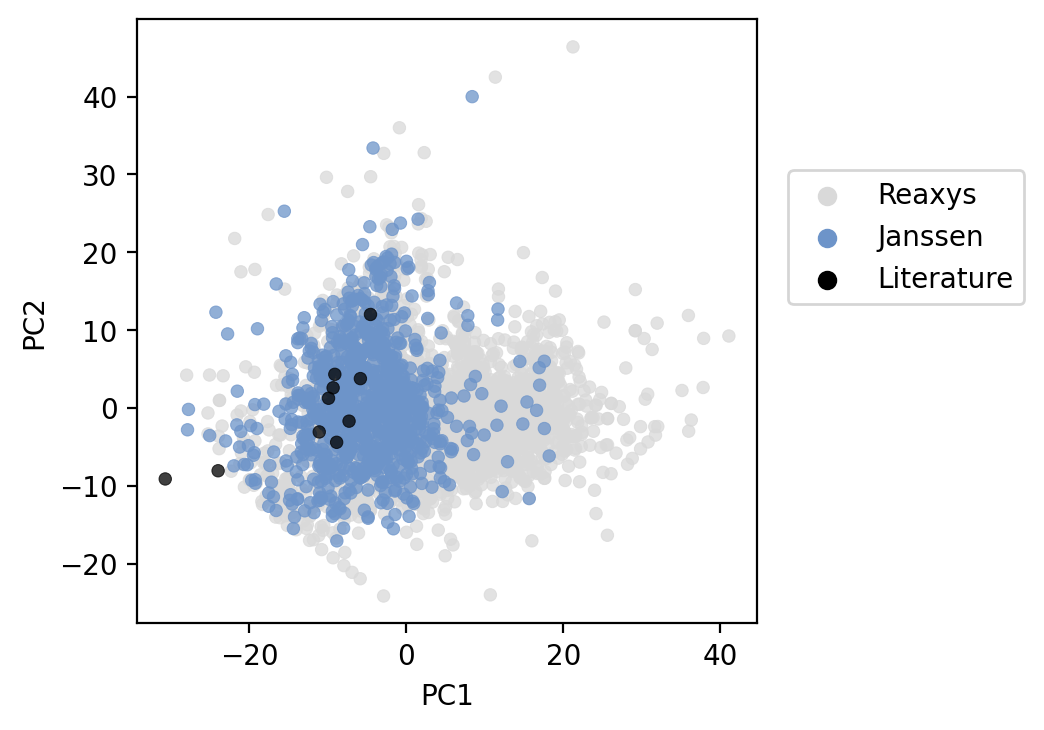

In [23]:
f = plt.figure(figsize=(4, 4), dpi=200)
color_threshold=0

palette = {'Janssen': '#6d94c9',
           'Reaxys': '#d9d9d9',
           'Literature': 'black'}

sns.scatterplot('PC1', 'PC2', data=pc_reduced, s=20, alpha=0.75, hue='type', palette=palette, edgecolor='face')
plt.legend(bbox_to_anchor=(1.05, 0.75), loc='upper left', borderaxespad=0)